In [4]:
from math import *
from nose.tools import assert_equal, ok_, assert_almost_equal
from utils import *
from tests import *
from copy import *

# Problem Set 08: Model Based Diagnosis and Conflicted Directed Search

In this problem set, we will model the probabilistic diagnosis problem and will practice transforming conflicts into diagnoses and obtaining the kernel diagnosis.

We will **not** be implementing a conflict-directed search algorithm directly. If that's something you want to learn, check out 16.412! However, it is important to understand the solvers we are likely to use will have these conflict-directed search techniques built into them.

0. [Credit for Contributors (required)](#contributors)

1. [Model Based Diagnosis (30 points)](#problem1)

2. [Generating Kernel Diagnoses from Conflicts (70 points)](#problem2)
 
    
**100 points** total for Problem Set 08


## <a name="contributors"></a> Credit for Contributors

List the various students, lecture notes, or online resouces that helped you complete this problem set:

Ex: I worked with Bob on the cat activity planning problem.

<div class="alert alert-info">
Write your answer in the cell below this one.
</div>

I worked with Tom Stuart, Anup, the Twins, and Skye Eiskowitz on every problem for this assignment. 


## Part 1: Model Based Diagnosis  <a name="problem1"></a>

### Problem 1 
Consider AND and XOR gates as shown below. We assign variables to the component state (A1 or X1), as well as the inputs (in1 and in2) and outputs (out). Write a sentence in the language of propositional logic that encodes the behavior of the gates. Assume that a value of `true` assigned to the component state means it is working correctly, while `false` implies it is in an unknown failure state. You can assume that a bit input/output of `1` is represented by `true` and `0` is represented by `false`.

<img src='ANDgate.png'/> <img src='XORgate.png'/> 

<div class="alert alert-info">
Write your propositional sentences for the two gates below.
</div>

**Propositional sentence for AND gate: (15 points)**

For the AND gate:<br />

And(1)= True: <br />
&emsp;     out(1) = in(1) AND in(2)<br />
And(1)= False:<br />
 &emsp;    True<br />
    
Thsi sentence is taken directly from slide 24 of lecture 13:<br />
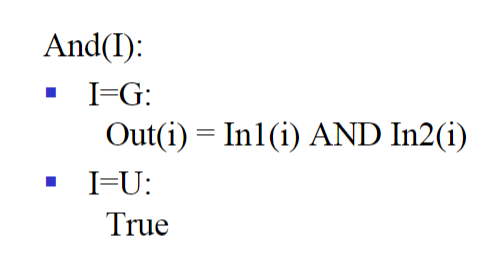

**Propositional sentence for XOR gate: (15 points)**

for the X1 XOR gate:<br />

XOR(1)=True:<br />
&emsp;    out(1) = in(1) XOR in(2)<br />

XOR(1)=False:<br />
&emsp;    out(1) = 0<br />

This is taken from slide 80 of the lectures:
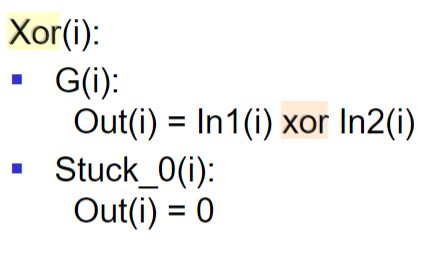

With these components we can now model the Boolean polycell example from class and feed them into a conflict-directed search algorithm to determine which components are most likely to be failing. We add some priors on the likelihood of failing, for example saying that XOR gates are 3% likely to fail and AND gates are 2% likely to fail. All components are assumed to fail independently. As we change the failure probabilities the solution will inevitabley change as well.

<img src='Polycell.PNG'/>

## Part 2: Generating Kernel Diagnoses from Conflicts  <a name="problem2"></a>

While performing search, conflicts are extracted that are used to further guide and refine our search. For now, let's assume we've been given a conflict, which will take the form of a set of two-element tuples. The first element of each tuple is the name of the decision variable for a component, and the second will be an assignment. As in part 1, we will use `1` to indicate a functional state, and `0` to indicate an unknown state. 

For example, we write the conflict {A1=G,A2=G,X1=G} as:

```python
set([('A1',1),('A2',1),('X1',1)])
```

### Problem 3 (10 points)

How, conceptually, might we verify that a given set of tuples is a conflict?

<div class="alert alert-info">
Answer the question in the space below.
</div>

Conceptually when we make an assignment of decision variables, there's a chance that other assignment results in an inconsistency amongst non-decision variables that contribute to the violation of some sort of constraint. This is called a conflict. For this reason, we verify that a given set of tuples is a conflict by looking at the non-decision variables once we have made an assignment. If there is some sort of inconsistency in the constraints given our variable assignment, we have found a conflict. If there isn't an inconsistency, we know that we don't have a conflict. 
<br />
<br />
<br />
<br />

This makes sense when you think about constraint-based versus conflict-directed A* search. Drawing on the work of Prof Williams, keeping something like constraint-based A* in mind, look at the pseudocode for constraint based A*:<br />
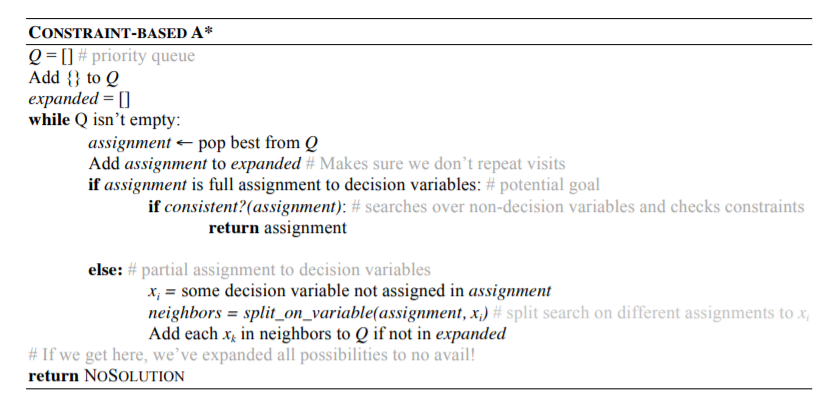

Transitioning from constraint-based to conflict direct... If I modify the consistent? component of the algo to search across non-decision variables, I can check to see if the assignment of decision variables is consistent but also if in the case of an inconsistency if there is a conflict:<br /><br />
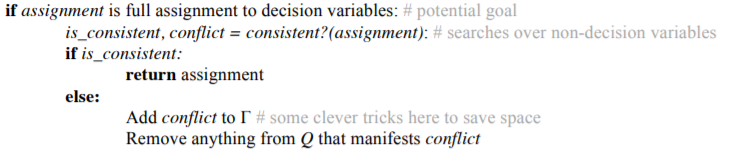

<br />
<br />
<br />
<br /> 

This is how Steve Levine explained the conflict verification step of conflict-directed A* in his Spring 2016 CDA gentle introduction for 16.412: https://ocw.mit.edu/courses/aeronautics-and-astronautics/16-412j-cognitive-robotics-spring-2016/related-resources/MIT16_412JS16_RR1.pdf

In a similar way, we will store each kernel diagnosis as a set, meaning that any assignment that is a superset of the kernel diagnosis satisfies all conflicts found so far. For example, a kernel diagnosis

```python
set([('A2',0),('X2',0)])
```

encodes that {A2=U,X2=U} solves all conflicts.

We will store all the kernel diagnoses as a list of sets, where each set is an individual kernel diagnosis.

### Problem 4 (50 points)
Implement the function `update_kernel_diagnoses` which updates the kernel diagnoses when a new conflict has been discovered. It takes as input:

* `kernel_diagnoses`: A list of sets representing the currently held kernel diagnoses.
* `conflict`: A set representing a conflict.

It outputs an updated set of kernel diagnoses that satisfy all conflicts. Remember you must handle the case where `kernel_diagnoses` is an empty list (no conflicts have yet been discovered).

You will receive no credit if you use existing set covering functions.

**Hint:** When we use sets the element ordering doesn't matter, so we can test equality between sets with `s1 == s2`. Add elements with `s1.add(el)`, and remove elements with `s1.remove(el)`. Test whether `s1` is a subset of `s2` with `s1.issubset(s2)`.

<div class="alert alert-info">
Implement `update_kernel_diagnoses`.
</div>

In [5]:
def update_kernel_diagnoses(kernel_diagnoses,conflict):
    output=[]
    kd=kernel_diagnoses
    c=conflict
    
    def diagnose(item):
        diagnosis=()
        if item[1]==1:
            diagnosis=(item[0],0)
        else:
            diagnosis=(item[0],1)
        return diagnosis
    
    candidates=set()
    for elem in c:
        candidates.add(diagnose(elem))
        
    if len(kd)==0:
        for el in candidates:
            output.append(set([el]))
    else:
        eliminated_list =[]
        for kernel in kd:
            if kernel.issubset(candidates):
                eliminated_list.append(kernel)
                for e in kernel:
                    candidates.remove(e)
                output.append(kernel)
                          
        for kernel in eliminated_list:
            kd.remove(kernel)
        
        for remaining_item in candidates:
            for remaining_kernel in kd:
                addition=set()
                addition.add(remaining_item)
                for thing in remaining_kernel:
                    addition.add(thing)
                output.append(addition)
    
    return output
    raise NotImplementedError()

In [6]:
test_update_kernel_diagnoses(update_kernel_diagnoses)

Test passed!!

### Problem 5 (10 points)
Finally, use `update_kernel_diagnoses` to implement `all_kernel_diagnoses`. This will take as input a list of conflicts, and return a list of all kernel diagnoses.

<div class="alert alert-info">
Implement `all_kernel_diagnoses.`
</div>

In [7]:
import pdb

def all_kernel_diagnoses(conflicts):
    # YOUR CODE HERE
    kd=[]
    for conflict in conflicts:
        kd=update_kernel_diagnoses(kd,conflict)
    return kd

In [8]:
test_all_kernel_diagnoses(all_kernel_diagnoses)

Test passed!!